# Dependencies

In [ ]:
#!pip install transformers torch

# Imports

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm.auto import tqdm
tqdm.pandas()

# Sentimental analysis

In [8]:
df = pd.read_csv("youtube_comments_with_dates.csv")

df["comment_published_at"] = pd.to_datetime(df["comment_published_at"], errors="coerce")
df["video_published_at"] = pd.to_datetime(df["video_published_at"], errors="coerce")

df.head()

,id,video_title,url,video_published_at,comment,comment_published_at,lemma_comment
0,ljMvbmmOigw,Military expert reacts to intensified fighting...,https://www.youtube.com/watch?v=ljMvbmmOigw,2025-11-03 15:15:07+00:00,Not much if an expert- he lies toi much and is...,2025-11-24 04:03:13+00:00,not much if an expert he lie toi much and be a...
1,ljMvbmmOigw,Military expert reacts to intensified fighting...,https://www.youtube.com/watch?v=ljMvbmmOigw,2025-11-03 15:15:07+00:00,Russia liberated 240 sq km of territory in Sep...,2025-11-24 03:55:20+00:00,russia liberate sq km of territory in sept sq ...
2,ljMvbmmOigw,Military expert reacts to intensified fighting...,https://www.youtube.com/watch?v=ljMvbmmOigw,2025-11-03 15:15:07+00:00,"Forget Trump, move on without him. Grab a toma...",2025-11-22 03:51:39+00:00,forget trump move on without he grab a tomahaw...
3,ljMvbmmOigw,Military expert reacts to intensified fighting...,https://www.youtube.com/watch?v=ljMvbmmOigw,2025-11-03 15:15:07+00:00,"Hij is misschien militair deskundige, maar zek...",2025-11-14 11:16:51+00:00,hij be misschien militair deskundige maar zeke...
4,ljMvbmmOigw,Military expert reacts to intensified fighting...,https://www.youtube.com/watch?v=ljMvbmmOigw,2025-11-03 15:15:07+00:00,worthless news !!,2025-11-14 04:19:47+00:00,worthless news


In [9]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

labels = ["negative", "neutral", "positive"]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
def sentiment_score(text):
    """
    Compute sentiment safely:
    - handles long texts
    - handles empty text
    - always returns float from -1 to +1
    """
    if not isinstance(text, str) or len(text.strip()) == 0:
        return 0.0

    try:
        encoded = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=512,      # FIXED, PREVENTS CRASH
        )

        with torch.no_grad():
            output = model(**encoded)

        scores = torch.softmax(output.logits, dim=1).numpy()[0]

        # continuous score: positive - negative
        return float(scores[2] - scores[0])

    except Exception:
        return 0.0

In [14]:
df["sentiment"] = df["comment"].astype(str).progress_apply(sentiment_score)
df.head()

  0%|          | 0/14109 [00:00<?, ?it/s]

,id,video_title,url,video_published_at,comment,comment_published_at,lemma_comment,sentiment
0,ljMvbmmOigw,Military expert reacts to intensified fighting...,https://www.youtube.com/watch?v=ljMvbmmOigw,2025-11-03 15:15:07+00:00,Not much if an expert- he lies toi much and is...,2025-11-24 04:03:13+00:00,not much if an expert he lie toi much and be a...,-0.762563
1,ljMvbmmOigw,Military expert reacts to intensified fighting...,https://www.youtube.com/watch?v=ljMvbmmOigw,2025-11-03 15:15:07+00:00,Russia liberated 240 sq km of territory in Sep...,2025-11-24 03:55:20+00:00,russia liberate sq km of territory in sept sq ...,-0.214784
2,ljMvbmmOigw,Military expert reacts to intensified fighting...,https://www.youtube.com/watch?v=ljMvbmmOigw,2025-11-03 15:15:07+00:00,"Forget Trump, move on without him. Grab a toma...",2025-11-22 03:51:39+00:00,forget trump move on without he grab a tomahaw...,0.103480
3,ljMvbmmOigw,Military expert reacts to intensified fighting...,https://www.youtube.com/watch?v=ljMvbmmOigw,2025-11-03 15:15:07+00:00,"Hij is misschien militair deskundige, maar zek...",2025-11-14 11:16:51+00:00,hij be misschien militair deskundige maar zeke...,0.029736
4,ljMvbmmOigw,Military expert reacts to intensified fighting...,https://www.youtube.com/watch?v=ljMvbmmOigw,2025-11-03 15:15:07+00:00,worthless news !!,2025-11-14 04:19:47+00:00,worthless news,-0.914275


In [15]:
df_daily = (
    df
    .set_index("comment_published_at")
    .sentiment
    .resample("D")
    .mean()
    .fillna(0)
)
df_daily.head()

,sentiment
comment_published_at,
2025-05-07 00:00:00+00:00,-0.122334
2025-05-08 00:00:00+00:00,-0.270427
2025-05-09 00:00:00+00:00,-0.086005
2025-05-10 00:00:00+00:00,-0.227704
2025-05-11 00:00:00+00:00,-0.727658


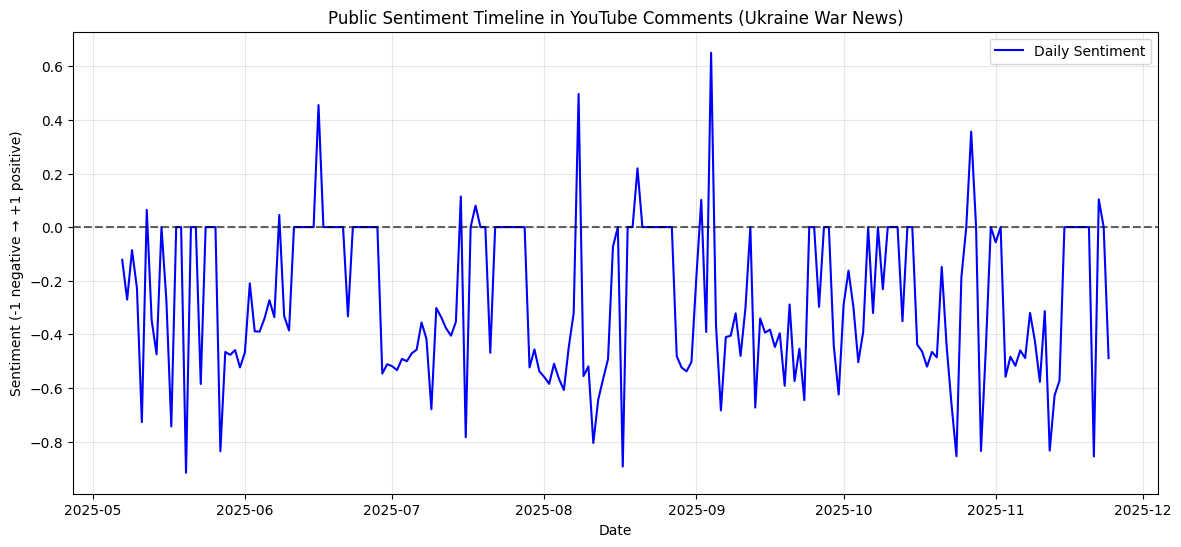

In [16]:
plt.figure(figsize=(14, 6))
plt.plot(df_daily.index, df_daily.values, label="Daily Sentiment", color="blue")

plt.axhline(0, color="black", linestyle="--", alpha=0.6)
plt.title("Public Sentiment Timeline in YouTube Comments (Ukraine War News)")
plt.xlabel("Date")
plt.ylabel("Sentiment (-1 negative → +1 positive)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

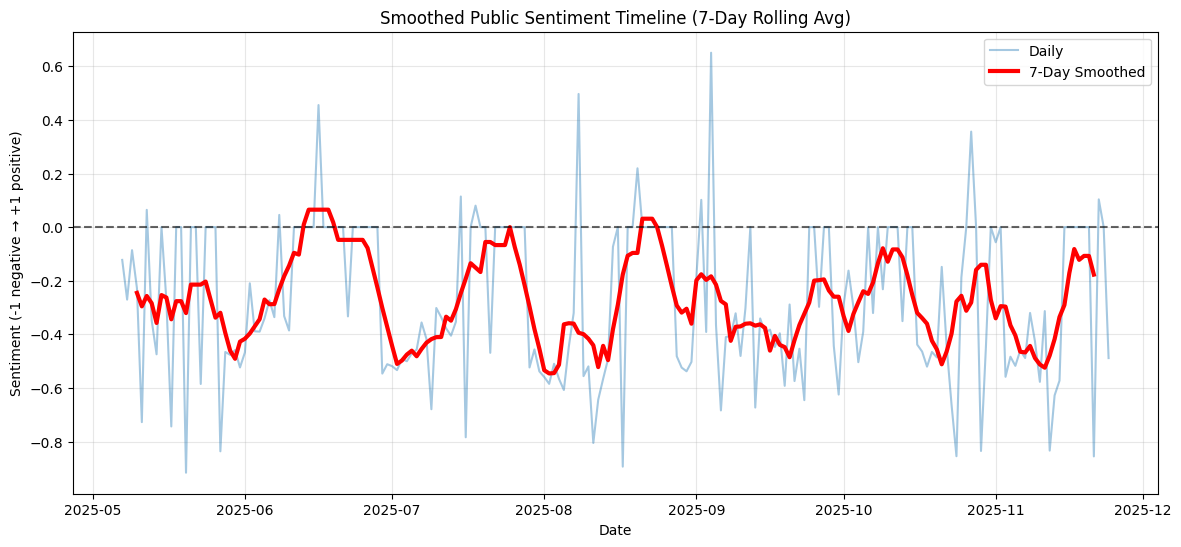

In [17]:
df_smooth = df_daily.rolling(7, center=True).mean()  # 7-day moving average

plt.figure(figsize=(14, 6))
plt.plot(df_daily.index, df_daily.values, alpha=0.4, label="Daily")
plt.plot(df_smooth.index, df_smooth.values, linewidth=3, color="red", label="7-Day Smoothed")

plt.axhline(0, color="black", linestyle="--", alpha=0.6)
plt.title("Smoothed Public Sentiment Timeline (7-Day Rolling Avg)")
plt.xlabel("Date")
plt.ylabel("Sentiment (-1 negative → +1 positive)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()